In [1112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

Prediction points > 12
0    9995
1    3635
Name: bps, dtype: int64
r^2: 0.749
Loss: 0.49694048452181283


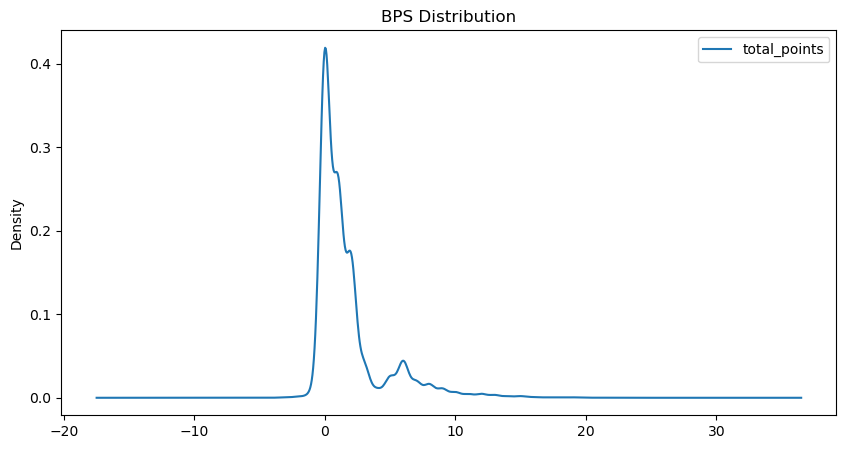

In [1155]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Load in the training data
training_data =  pd.read_csv('training_data_3.csv')

# Set the qunatile we want to predict, change this number for different results
PREDICTION_QUANTILE = .75

# Find how many BPS points is the cutoff for the quantile
quantile_points = training_data['bps'].quantile(PREDICTION_QUANTILE)
# Create a new column that is 1 if the player scored more than the quantile cutoff, 0 otherwise
training_data['bps'] = training_data['bps'].apply(lambda x: 1 if x >= math.floor(quantile_points) else 0)

# Plot the distribution of BPS points and print out some stats
training_data.filter(['total_points']).plot.kde(title='BPS Distribution', figsize=(10, 5))
print('Prediction points >', math.floor(quantile_points))
print(training_data['bps'].value_counts())

# Split the data into X and Y, X is all the inputs and Y is the column of 1's and 0's we just created
Y = training_data.values[:, 1]
X = training_data.values[:, 5:]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=3)

# Train the classifier model: 3 hidden layers with 1500 nodes each, adaptive learning rate, early stopping
clf = MLPClassifier(max_iter=1000, random_state=1, learning_rate='adaptive', early_stopping=True, hidden_layer_sizes=(1500,1500,1500)).fit(X_train, Y_train)

# Test the model and print out the results. r^2 is the accuracy of the model, closer to 1 is better. Loss is the difference between the predicted and actual values, lower is better
result = clf.score(X_test, Y_test)
print("r^2: %.3f" % result)
print('Loss: {0}'.format(clf.loss_))


In [1156]:
# Load in the player and team data, and the fixtures for the next 5 gameweeks, we will use these to predict the points
player_df = pd.read_csv('player_overall_2022.csv')
team_df = pd.read_csv('teams_overall_2022.csv')
fixtures = [{
    "Burnley": "Manchester City",
    "Arsenal": "Nottingham Forest",
    "Bournemouth": "West Ham",
    "Brighton": "Luton",
    "Everton": "Fulham",
    "Sheffield United": "Crystal Palace",
    "Aston Villa": "Newcastle",
    "Brentford": "Tottenham",
    "Chelsea": "Liverpool",
    "Manchester United": "Wolverhampton Wanderers",
},{
    "Nottingham Forest": "Sheffield United",
    "Fulham": "Brentford",
    "Bournemouth":"Liverpool",
    "Brighton": "Wolverhampton Wanderers",
    "Manchester United": "Tottenham",
    "Newcastle": "Manchester City",
    "Everton": "Aston Villa",
    "Chelsea": "West Ham",
    "Crystal Palace": "Arsenal",
},{
    "Chelsea": "Luton",
    "Bournemouth": "Tottenham",
    "Arsenal": "Fulham",
    "Brentford": "Crystal Palace",
    "Everton": "Wolverhampton Wanderers",
    "Manchester United": "Nottingham Forest",
    "Brighton": "West Ham",
    "Burnley": "Aston Villa",
    "Sheffield United": "Manchester City",
    "Liverpool": "Newcastle",
},
{
    "Luton": "West Ham",
    "Sheffield United": "Everton",
    "Brentford": "Bournemouth",
    "Burnley": "Tottenham",
    "Brighton": "Newcastle",
    "Nottingham Forest": "Chelsea",
    "Fulham": "Manchester City",
    "Crystal Palace": "Wolverhampton Wanderers",
    "Aston Villa": "Liverpool",
    "Manchester United": "Arsenal",
},
{
    "Wolverhampton Wanderers": "Liverpool",
    "Aston Villa": "Crystal Palace",
    "Fulham": "Luton",
    "Manchester United": "Brighton",
    "Tottenham": "Sheffield United",
    "West Ham": "Manchester City",
    "Everton": "Arsenal",
    "Bournemouth": "Chelsea",
    "Newcastle": "Brentford",
    "Everton": "Arsenal",
    "Nottingham Forest": "Burnley",
}
]

In [1157]:
# Create a reverse fixture list so we can get the opponent for each team
reverse_fixture = {}
for fixture in fixtures:
    for team, opponent in fixture.items():
        reverse_fixture[opponent] = team
    
    fixture.update(reverse_fixture)
    reverse_fixture = {}

# Create a list of all the columns we want don't need
cols_to_drop = ['id', 'games','time','yellow_cards', 'red_cards', 'position', 'team_title', 'fixture', 'player_team', 'team']

# Rename some of the columns and team names so we can merge the dataframes
team_df['team'] = team_df['team'].replace({'Leeds':'Burnley','Leicester':'Luton', 'Southampton':'Sheffield United'})
opp_team_df = team_df.rename(columns={'shots':'opp_shots','goals':'opp_goals','xG':'opp_xG','against_shots':'against_opp_shots','against_goals':'against_opp_goals','against_xG':'against_opp_xG'})
team_df = team_df.rename(columns={'team':'player_team','shots':'team_shots','goals':'team_goals','xG':'team_xG','against_shots':'against_team_shots','against_goals':'against_team_goals','against_xG':'against_team_xG'})
player_df['team_title'].replace({'Manchester City':'Manchester_City','Manchester United': 'Manchester_United','Newcastle United': 'Newcastle_United', 'Nottingham Forest': 'Nottingham_Forest', 'West Ham': 'West_Ham', 'Crystal Palace': 'Crystal_Palace', 'Aston Villa': 'Aston_Villa', 'Wolverhampton Wanderers': 'Wolverhampton_Wanderers'}, inplace=True)
opp_team_df['team'].replace({'Manchester City':'Manchester_City','Manchester United': 'Manchester_United','Newcastle United': 'Newcastle_United', 'Nottingham Forest': 'Nottingham_Forest', 'West Ham': 'West_Ham', 'Crystal Palace': 'Crystal_Palace', 'Aston Villa': 'Aston_Villa', 'Wolverhampton Wanderers': 'Wolverhampton_Wanderers'}, inplace=True)
player_df['fixture'] = player_df['team_title']

# This array will hold all the dataframes we want to predict
frames_to_predict = []

# For each fixture, merge the player, team, and opponent team dataframes, drop the columns we don't need, and drop any rows with missing values
for fixture in fixtures:
    for team, opponent in fixture.items():
        player_df['fixture'] = player_df['fixture'].replace({team:opponent})
        
    frames_to_predict.append(player_df.merge(team_df, how='left', left_on='team_title', right_on='player_team').merge(opp_team_df, how='left', left_on='fixture', right_on='team').drop(cols_to_drop, axis=1).dropna())


C:\Users\patri\AppData\Local\Temp\ipykernel_2564\2037190054.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(final_results.keys(), rotation=90)


{'Bruno Fernandes': 5, 'Douglas Luiz': 5, 'Rúben Neves': 5, 'Jacob Ramsey': 5, 'Emiliano Buendía': 5, 'Casemiro': 5, 'Declan Rice': 5, 'Bruno Guimarães': 5, 'Alex Iwobi': 5, 'Rodri': 5, 'Kieran Trippier': 5, 'Tyrone Mings': 5, 'Ezri Konsa Ngoyo': 5, 'Antonee Robinson': 5, 'Pascal Groß': 4, 'Tim Ream': 4, 'Moisés Caicedo': 4, 'Mohamed Salah': 3, 'Martin Odegaard': 3, 'Jefferson Lerma': 3, 'Pierre-Emile Højbjerg': 3, 'Virgil van Dijk': 3, 'Thomas Partey': 3, 'Trent Alexander-Arnold': 3, 'Fabinho': 3, 'Mathias Jensen': 2, 'Eric Dier': 2, 'Cristian Romero': 2, 'Gabriel Martinelli': 2, 'Bukayo Saka': 2, 'Granit Xhaka': 2, 'Gabriel': 2, 'Ben White': 2, 'Oleksandr Zinchenko': 2, 'Bryan Mbeumo': 1, 'Harrison Reed': 1}


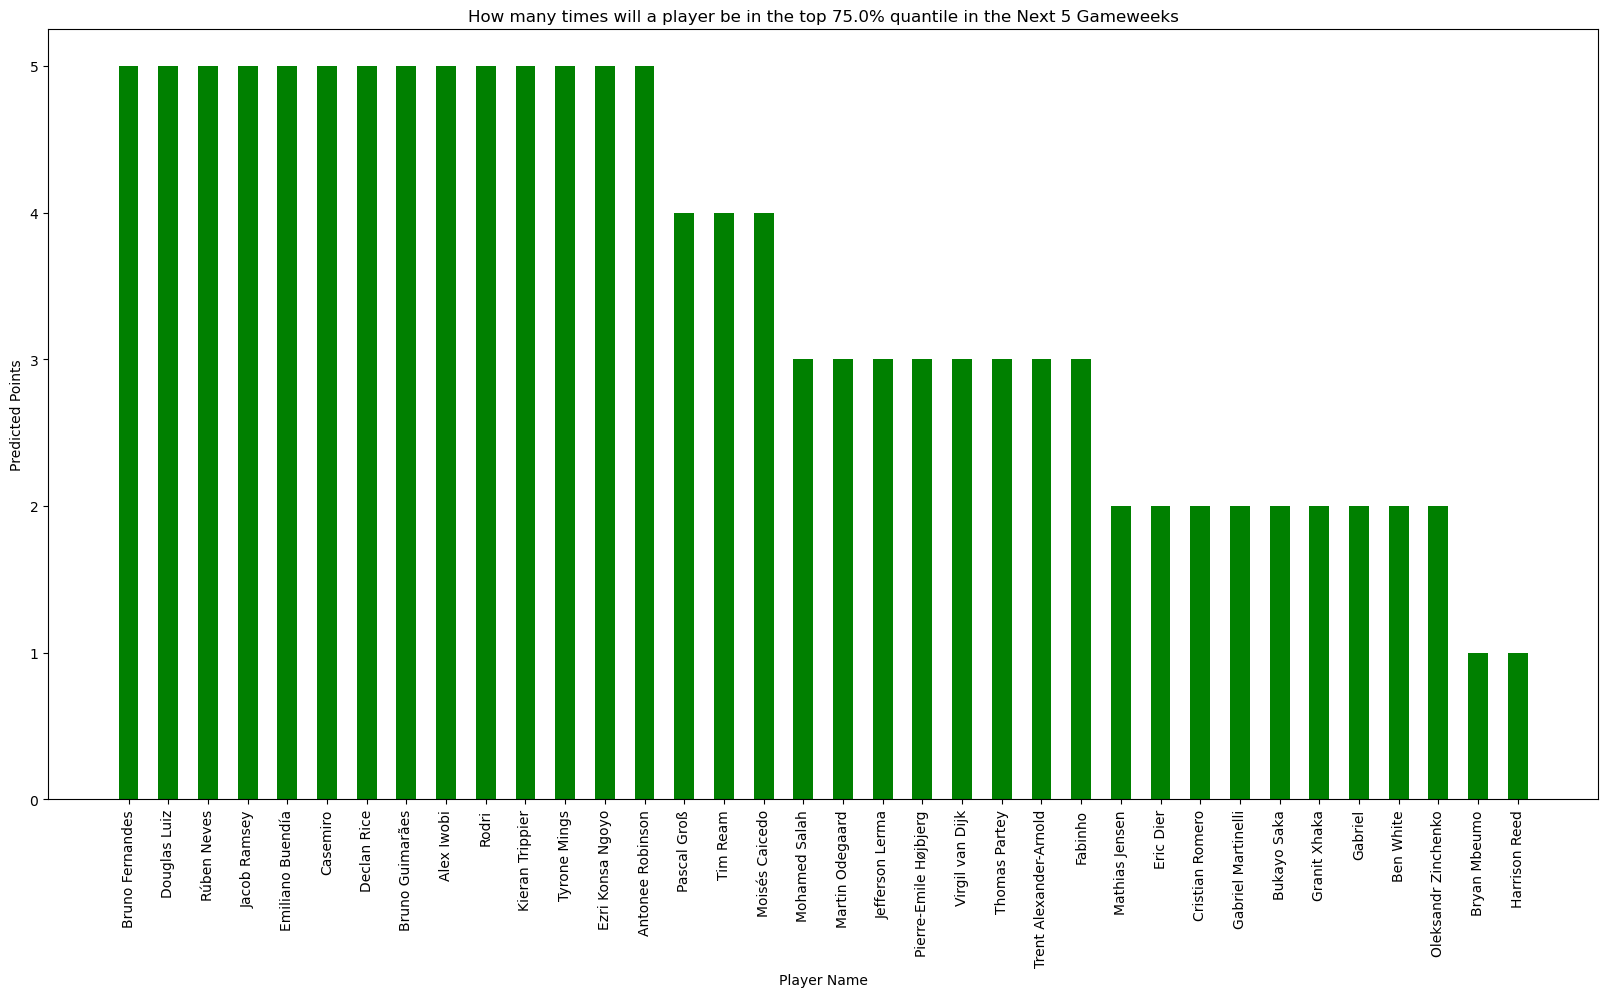

In [1158]:
# Concatenate all the dataframes into one big dataframe
final_frame = pd.concat(frames_to_predict)

# Make predictions on the dataframe
results = clf.predict(final_frame.values[:, 2:])

# Create a dictionary to hold the results
final_results = {}

# For each player, add up the number of times they were predicted to score more than the quantile cutoff
for i in range(len(results)):
    if results[i] == 1:
        if final_frame['player_name'].values[i] in final_results:
            final_results[final_frame['player_name'].values[i]] += 1
        else:
            final_results[final_frame['player_name'].values[i]] = 1

# Sort the results
final_results = {k: v for k, v in sorted(final_results.items(), key=lambda item: item[1], reverse=True)}

# Plot the results
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(final_results.keys(), final_results.values(), color='g', width=0.5 )
ax.set_xticklabels(final_results.keys(), rotation=90)
ax.set_title('How many times will a player be in the top {}% quantile in the Next 5 Gameweeks'.format(PREDICTION_QUANTILE*100))
ax.set_ylabel('Predicted Points')
ax.set_xlabel('Player Name')

print(final_results)
